# True or False

1. False
2. True (The magnitudes are symmetric)
3. True
4. True
5. True (STFT is used as a process to obtain a spectrogram, further steps are needed to one one to another)
6. False 
7. False
8. True

# Definitions

9. Window functions are applied on a time domain signal before it undergoes a discrete fourier tranform, to reduce the effect of spectral leakage, cause by non-complete periods present in the signal. 

 


10. Log-frequency spectrum is the frequency spectrum scaled logarithmically. This enables us to observe the frequency content of a audio signal in musical way, as it resembles the way humans perceive pitch. Similarly, it also makes pitch classes easier to identify on the spectrum.



11. Spectral Centroid is an audio feature that describes "the center of mass" of an audio signal on the frequency domain. Perceptually, it resembles what human hears as the "brightness" of sound. 



12. Feature vector is an agregate of features obtained from an input source (images, audio, motion etc.), organized in a single mathematical vector. A good example of this is a single frame of an MFCCs. It contains multiple features that describes a single input (audio), organized inside a vector space. It enables us to perform signal processing tasks very efficiently. 


13. In machine learning, f-measure evaluates the accuracy of a trained model, by comparing its outputs to the correct label. It's computed as : 2 * ( Precision * Recall ) / ( Precision + Recall )



14. Timbre describes the spectral characterisitcs of a particular sound that is distinct from pitch and loudness. A typical example is the sound characteristic that separates a violin and a flute playing the same note at the same intensity.

# Short Answer

In [1]:
midi_note = 100
frequency = 2**((midi_note - 69) / 12) * 440
frequency

2637.02045530296

15. According to the above formula, MIDI Note 100 corresponds to 2637 Hz. 

16. 100ms = 0.1s, frequency = 1/Period = 10 Hz
Therefore, the frequency of x[n] is 10 Hz

17. Bin width = sample_rate / num_samples = 10000 / 50 = 200 Hz

18. 

In [2]:
frame_index = 100
hop_size = 250
fs = 5000

sample_index = frame_index * hop_size
time_location = sample_index * ( 1 / fs )
time_location

5.0

The STFT bin X[2000, 100] corresponds to 5 seconds in time.

19. 

In [3]:
1 / ( 2000 * ( 1 / 48000 ) )

24.0

The sample rate of the novelty function is 24 Hz

20. The Nyquist Frequency of fs = 22050 Hz is 11025 Hz

21. The zero crossing rate is 200 / 2000 = 0.1 ( times / sample )

22. The column number will stay the same as the amount of features. The number of feature samples would be the number of audio samples divided by the hop size, calculations below:

In [3]:
num_samples = 10000 * 30
num_feature_samples = num_samples / hop_size
num_feature_samples

600.0

Thus the dimensions will be (1200, 10)

# Implementation

## 23. Note Onset with Spectral Flux

### a)  Briefly describe the goal of note onset detec- tion

The goal of the note onset function is to find out the time domain locations where new notes are being played.

### b) Plot a spectrogram of the audio, correctly labeled, and describe what parameters you used and why you chose those parameters.

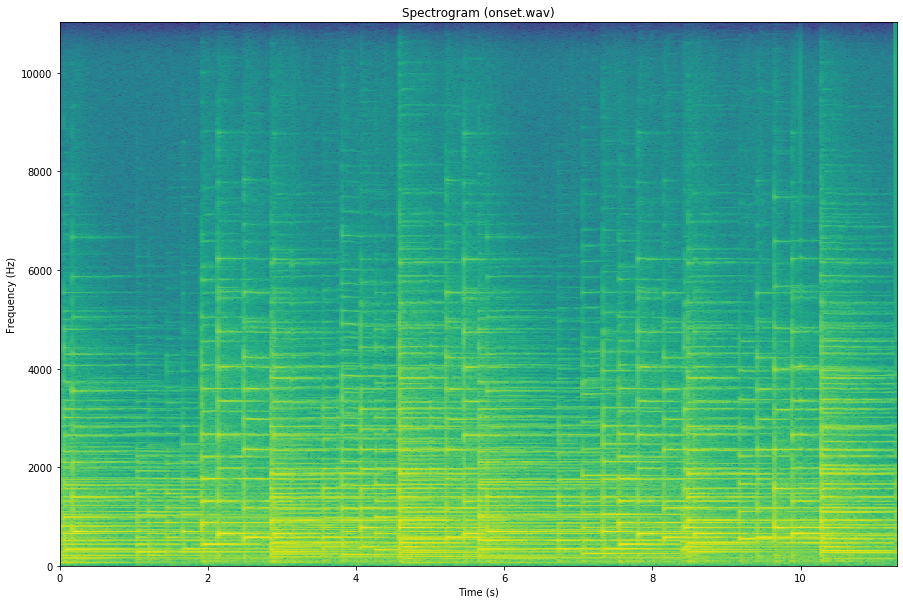

In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy
plt.rcParams['figure.figsize'] = (15,10)

# load audio file
data, fs = librosa.load("onset.wav")

# perfrom STFT on the audio signal for the spectrogram. 
# I chose nfft to be 2048 at this point because I want to have high frequency resolution
# to look at what's contained in this audio sample. I chose the hop size to be 512 so I 
# can have a somewhat high time resolution, to see how the frequencies are progressing
# in the time domain. These information will help me determine the running average and 
# running max window sizes later on.
STFT = librosa.core.stft( data, n_fft = 2048, hop_length = 512, window='hann')

# Taking the magnitude of the results
STFT = np.abs( STFT )

# Converting to log scale
STFT = 10 * np.log(STFT)

# normalizing the time axis for plotting
t = np.linspace(0, len(data)/fs, STFT.shape[1] + 1)  

# normalizing the frequency axis for plotting
plt.xlabel('Time (s)')
f = np.linspace(0, fs/2, STFT.shape[0] + 1)                        
plt.ylabel('Frequency (Hz)')
plt.title( "Spectrogram (onset.wav)")

# Plotting
plot = plt.pcolormesh(t, f, STFT)

 ### (c) Describe the spectral flux calculation without using the equation.

The idea of spectral flux is simple. After the spectrogram of the signal is computed, we find out the difference
of magnitudes across the spectrum on a frame by frame basis. We use this difference to generate a novelty curve, which informs us how the magnitudes are changing in time, which gives us insights on when onsets might occur

### (d) Describe the process of peak-picking as it relates to the novelty function and note onsets. Describe the parameters you chose and your reasoning.

Peak peaking is the process of picking out note onsets from a previously generated novelty curve. It calculates a running average and running max of the novelty curve as a guideline for determining an onset. If a value is above the running average, as well as being the local maxima, we determine it as a note onset. The functions are copied from previous homework. 

In [6]:
def spectral_flux_novelty(x, win_size, hop_size, gamma):
    
    """ Calulate a spectral flux novelty curve
    
    Parameters
    ----------
    
    x: np.array
        input audio
    
    win_size: int
        window size (samples)
    
    hop_size: int
        hop size (samples)
        
    Returns
    -------
    
    novelty: np.array
        novelty curve
        
    """
    
    # Obtain STFT matrix through librosa.stft
    STFT = librosa.core.stft(x, n_fft = win_size, hop_length = hop_size, win_length = win_size, window = 'hann')
    
    # Log scale the frequency axis for better recognition of onsets
    STFT = np.log( 1 + gamma * np.abs(STFT) )
    
    # Sum up the the magnitudes contained in each time slice
    STFT_sum = np.sum(STFT, axis = 0)
    
    # Calculate the differences between each frame, resulting array will be one shorter
    STFT_diff = np.diff(STFT_sum)
    
    # Setting negative values to zero
    STFT_diff[STFT_diff < 0] = 0
    
    # Return the novelty curve
    return STFT_diff

def detect_onsets (n_fn, mean_len, max_len, delta):
    
    """ Detect onsets from a novelty curve
    
    Parameters
    ----------
    
    n_fn: np.array
        input novelty curve
    
    mean_len: int
        before and after each sample, used to calculate threshold
    
    max_len: int
        window around n used to determine if n is a peak
        
    delta: int
         amount to vertically adjust the threshold (start with delta = 0.05)
      
    
    Returns
    -------
    
    onsets: np.array
        detected onsets (frame number)

    """
    
    # Setting up an empty running_average array
    running_average = []
    
    # This calculate the running max by appending the front and end with the smallest value of n_fn
    running_max = scipy.ndimage.maximum_filter1d( n_fn, max_len , 
                                                  mode = 'constant', 
                                                  cval = n_fn.min())
    
    # Starting at mean_len, this means all samples before this need to be computed later.
    start = mean_len
    
    # This calculates the running average of the samples, excluding front and end mean_len samples
    while (start + mean_len < len( n_fn )) :   
        average = np.mean( n_fn[start - mean_len : start + mean_len] )     
        running_average.append( average )   
        start += 1 
                
    # Calculating the running average of the first mean_len samples
    beginning_average = []
    start = 1
    while start <= mean_len:
        average = np.mean(n_fn[ : start + mean_len])
        beginning_average.append(average)
        start += 1
        
    running_average = np.append(beginning_average, running_average)
        
    # Calculating the ending mean_len samples's running average
    ending_average = []
    start = len(n_fn) - mean_len
    
    while start < len(n_fn) :
        average = np.mean(n_fn[start - mean_len : ])
        ending_average.append(average)
        start += 1
    
    running_average = np.append( running_average, ending_average )
    
    # Visualizing the running average vs original novelty curve
    plt.plot(n_fn, label = 'novelty curve')
    plt.plot(running_average + delta, label = 'running average')
    plt.plot(running_max, label = 'running max')
    plt.legend()
    
    # Finally, compare samples with our running_average and running_max array to determine onsets
    onset_frames = []
    for i in range(0, len(n_fn)):
        if ( n_fn[i] == running_max[i] and n_fn[i] >= ( running_average[i] + delta ) ):
            onset_frames.append(i)
    
    return np.array(onset_frames)

### (e) Plot the output novelty function, correctly labeled, with the selected peaks marked.

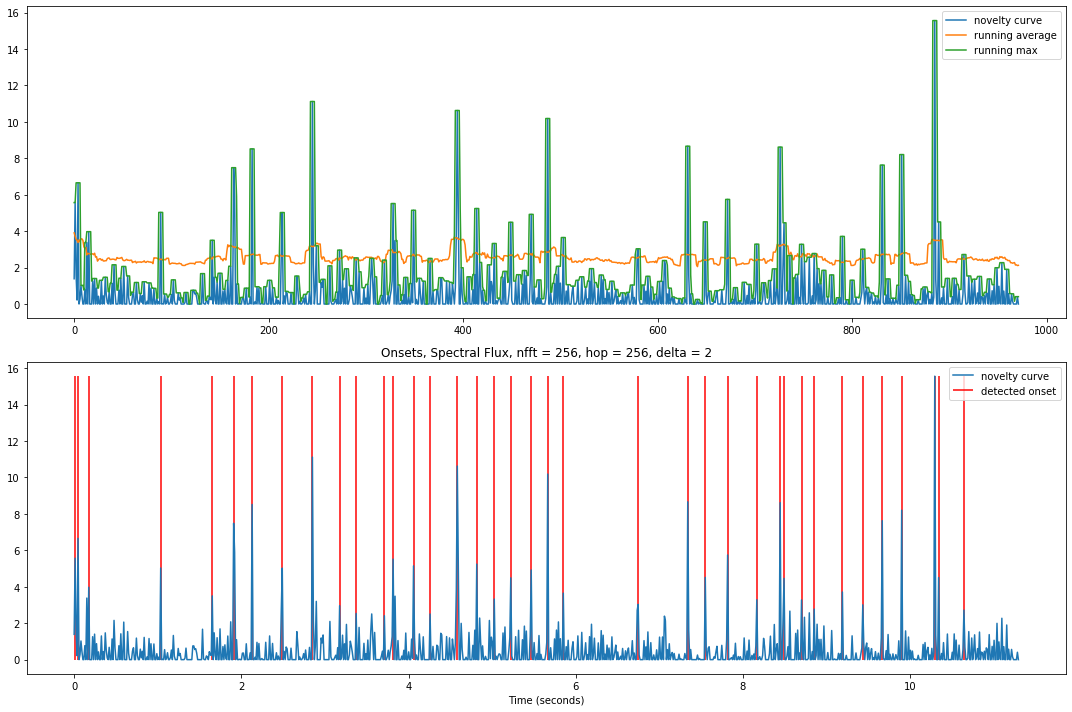

In [7]:
x, fs = librosa.load("onset.wav")
assert fs == 22050
N = len(x)
T = N/fs

#-------------------------#
#   Spectral Flux Curve   #
#-------------------------#
plt.subplot(211)
gamma = .5
s_novelty = spectral_flux_novelty(data, 256, 256, gamma)
time_vector = np.linspace(0, T, len(s_novelty))

#-------------------------#
#     Onset-Detection     #
#-------------------------#
delta = 2
# 8, and 5 below corresponds to around 100 ms and 60ms. 
# These are used for the running average and running max windows
# I chose them because they give me the best onsets for this sample. 
onset_frames = detect_onsets(s_novelty, 8, 5, delta)

#-------------------------#
#        Plotting         #
#-------------------------#
plt.subplot(212)
plt.xlabel('Time (seconds)')
plt.title('Onsets, Spectral Flux, nfft = 256, hop = 256, delta = {}'.format(delta))

plt.plot(time_vector,  s_novelty, label = 'novelty curve')
plt.vlines(time_vector[onset_frames], 0, s_novelty.max(), linestyles='solid', color='r', label = 'detected onset')
plt.legend()
plt.tight_layout()

from IPython.display import Audio
Audio(data = x, rate = fs)